In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from helper import *
import random

In [84]:
def load_data():
    X = np.load("data/X.npy") 
    y = np.load("data/y.npy")
    return split_data(X, y)

def split_data(X, y, train_size = 0.7):
    """
    Return a dictionary containing the traning set, validation set and the test set
    """
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=train_size)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size=0.5)
    data = {"train": (X_train, y_train), "val": (X_val, y_val), "test": (X_test, y_test)}
    return data

In [85]:
data = load_data()

In [86]:
print("X_train shape is {}".format(data['train'][0].shape))
print("y_train shape is {}".format(data['train'][1].shape))
print("X_val shape is {}".format(data['val'][0].shape))
print("y_val shape is {}".format(data['val'][1].shape))
print("X_test shape is {}".format(data['test'][0].shape))
print("y_test shape is {}".format(data['test'][1].shape))

X_train shape is (3500, 400)
y_train shape is (3500, 1)
X_val shape is (750, 400)
y_val shape is (750, 1)
X_test shape is (750, 400)
y_test shape is (750, 1)


In [87]:
def knn_init_centroids(X, K):
    """
    Return an array of initialized K centroids using the data point in X
    """
    
    random_idx = np.random.permutation(X.shape[0])
    centroids = X[random_idx[:K]]
    
    return centroids

In [88]:
def closest_centroids(X, centroids):
    """
    Return an array of ints that represents the closest centroid to each example.  
    """
    m, n = X.shape
    K = centroids.shape[0]
    
    idx = np.zeros(m, dtype=int)
    
    for i in range(m):
        # X[i] - centroids will gives us a K * n matrix and then setting axis = 1 will find the euclidean distance
        # of the numbers in each row. Output is (K,) array contains the distance of X[i] to each of the centroids.
        distance = np.linalg.norm((X[i] - centroids), axis = 1)
        idx[i] = np.argmin(distance, axis = 0)
        
    return idx

In [89]:
def reassign_centroids(X, idx, K):
    """
    Return an new arrray of centroids where each centroid is reassigned by calculating the mean of each 
    data points assigned to each centroid
    """
    
    m, n = X.shape
    centroids = np.zeros((K, n))
    
    for i in range(K):
        points = X[idx == i]
        centroids[i] = np.mean(points, axis = 0) 

    return centroids

In [90]:
def run_knn(X, init_centroids, max_iters=20):
    """
    Return the centroids and an array idx that indicates the closest centroid to each example after running 
    max_iters iterations of the K-Means algorithm on data matrix X
    """
    
    m, n = X.shape
    K = init_centroids.shape[0]
    centroids = init_centroids
    idx = np.zeros(m)
    
    for i in range(max_iters):        
        idx = closest_centroids(X, centroids)
        centroids = reassign_centroids(X, idx, K)
        
    return centroids, idx

In [91]:
def predict(X, y, centroids, idx):
    """
    Return the prediction of each centroids based on the number of data points belonging to the same 
    centroid and their true value
    """
    
    m, n = X.shape
    K = centroids.shape[0]
    # find the unique values in y
    classes = np.unique(data['train'][1])
    prediction = np.zeros(K, dtype=int)
    
    for i in range(K):
        # neighbor is all the data points that are neighbors of centroid[i]
        neighbor = X[idx == i]
        # label is the true value of those data points neighboring centroids[i]
        label = y[idx == i]
        # lebel == classes will result in a m*10 matrix since there are 10 unique numbers in y.
        # Then setting axis = 0 will give us the sum of values equal to 0, 1, ..., 9 respectively, and dividing
        # them by the number of examples will gives us the probabilities 
        # sometime a centroid would not have any neighbor, so label.shape[0] would be 0 and cause divide by 0 error
        # ignore this case
        np.seterr(divide='ignore', invalid='ignore')
        pred = np.sum(label == classes, axis = 0) / label.shape[0]
        np.seterr(divide='warn', invalid='warn')
        # find the class with the largest probability
        prediction[i] = classes[np.argmax(pred)]
    
    return prediction

In [92]:
def optimal(data, K, max_iter):
    """
    find the number of centroids and number of iterations that fit the training set and output the
    best accuracy for the validation set, then using the optimal k and iterations to fit the test set
    """
    
    m_train, n_train = data['train'][0].shape
    m_val, n_val = data['val'][0].shape
    m_test, n_test = data['test'][0].shape
    best_k = 0
    best_iter = 0
    best_acc = 0
    best_train = 0
    
    for k in K:
        for i in max_iter:
            init_centroids = knn_init_centroids(data['train'][0], k)
            centroids, idx = run_knn(data['train'][0], init_centroids, i)
            valid_idx = closest_centroids(data['val'][0], centroids)

            prediction = predict(data['train'][0], data['train'][1], centroids, idx)
            prediction_val = predict(data['val'][0], data['val'][1], centroids, valid_idx)
            # each element in prediction is the true label each centroid represents
            # prediction[idx] will result in a (m,) array where each value is the true label of each centroid that 
            # is closest to the example
            y_pred = prediction[idx].reshape(m_train, -1)
            acc = np.sum(y_pred == data['train'][1]) / m_train
            
            y_pred_val = prediction_val[valid_idx].reshape(m_val, -1)
            acc_val = np.sum(y_pred_val == data['val'][1]) / m_val

#             print("training set, k: {}, max_iter: {}, accuracy: {}".format(k, i, acc))
#             print("validation set, k: {}, max_iter: {}, accuracy: {}".format(k, i, acc_val))

            if best_acc < acc_val:
                best_acc = acc_val
                best_k = k
                best_iter = i
                best_train = acc
                
    print("best_k: {}, best_max_iter: {}".format(best_k, best_iter))
    print("training set accuracy: {}".format(best_train))
    print("validation set accuracy: {}".format(best_acc))
    
    init_centroids = knn_init_centroids(data['test'][0], best_k)
    centroids, idx = run_knn(data['test'][0], init_centroids, best_iter)
    prediction = predict(data['test'][0], data['test'][1], centroids, idx)
    y_pred = prediction[idx].reshape(m_test, -1)
    acc = np.sum(y_pred == data['test'][1]) / m_test
    print("test set accuracy: {}".format(acc))


In [93]:
K = [50, 70, 100, 150]
max_iter = [10, 20, 30, 40, 50]

optimal(data, K, max_iter)

best_k: 150, best_max_iter: 50
training set accuracy: 0.8728571428571429
validation set accuracy: 0.8906666666666667
test set accuracy: 0.8586666666666667


In [94]:
def error_and_real(X, y, K, max_iter):
    
    m, n = X.shape
    init_centroids = knn_init_centroids(X, K)
    centroids, idx = run_knn(X, init_centroids, max_iter)
    prediction = predict(X, y, centroids, idx)
    y_pred = prediction[idx].reshape(m, -1)
    err = y_pred != y  
    err = np.squeeze(err)
    err_y = y_pred[err]
    err_X = X[err]
    real = y_pred == y  
    real = np.squeeze(real)
    real_y = y_pred[real]
    real_X = X[real]

    print("{} error out of {} image in test set".format(err_X.shape[0], m))
    return err_X, err_y, real_X, real_y

In [95]:
X = data['test'][0]
y = data['test'][1]
err_X, err_y, real_X, real_y = error_and_real(X, y, 200, 40)

90 error out of 750 image in test set


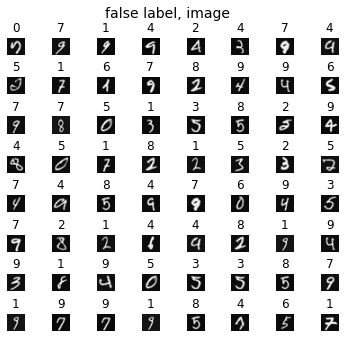

In [96]:
"""
Display some of the misclassified images with their predicted labels
"""
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = err_X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

#fig.tight_layout(pad=0.5)
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = err_X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(err_y[random_index,0])
    ax.set_axis_off()
    fig.suptitle("false label, image", fontsize=14)

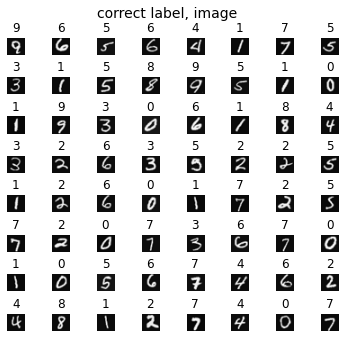

In [97]:
"""
Display some of the correctly classified images
"""
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = real_X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

#fig.tight_layout(pad=0.5)
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = real_X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(real_y[random_index,0])
    ax.set_axis_off()
    fig.suptitle("correct label, image", fontsize=14)

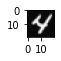

Prediction: [4]


In [98]:
image_ex = real_X[123]
display_digit(image_ex)
print("Prediction: {}".format(real_y[123]))

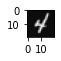

Prediction: [9]


In [99]:
image_ex = err_X[5]
display_digit(image_ex)
print("Prediction: {}".format(err_y[5]))